## Visualized loss 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
import cv2
import numpy as np
import os
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

# 檢查是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定義動態卷積模塊
class DynamicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(DynamicConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # 動態權重生成網絡
        self.weight_gen = nn.Sequential(
            nn.Linear(in_channels, in_channels * out_channels * kernel_size * kernel_size),
            nn.ReLU(),
            nn.Linear(in_channels * out_channels * kernel_size * kernel_size, out_channels * in_channels * kernel_size * kernel_size)
        )

    def forward(self, x):
        batch_size, _, _, _ = x.size()
        weights = self.weight_gen(x.mean([2, 3])).view(batch_size, self.out_channels, self.in_channels, self.kernel_size, self.kernel_size)
        weights = weights.view(batch_size * self.out_channels, self.in_channels, self.kernel_size, self.kernel_size)
        
        # 需要調整輸入的形狀以匹配新的卷積核
        x = x.view(1, batch_size * self.in_channels, x.size(2), x.size(3))
        output = F.conv2d(x, weights, stride=self.stride, padding=self.padding, groups=batch_size)
        
        # 調整輸出形狀以恢復原始的batch size
        output = output.view(batch_size, self.out_channels, output.size(2), output.size(3))
        return output

# 定義RRDB模塊
class RRDB(nn.Module):
    def __init__(self, in_channels, growth_channels):
        super(RRDB, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, growth_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(growth_channels, growth_channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(growth_channels, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        residual = x
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = self.conv3(out)
        return out + residual

# 定義CustomCNN_DynamicConv2d_RRDB模型
class CustomCNN_DynamicConv2d_RRDB(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN_DynamicConv2d_RRDB, self).__init__()
        self.dynamic_conv = DynamicConv2d(3, 64, kernel_size=3, padding=1)
        self.rrdb1 = RRDB(64, 32)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128 * 32 * 32, num_classes)

    def forward(self, x):
        x = F.relu(self.dynamic_conv(x))
        x = self.rrdb1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x

# 定義數據集類
class ImageDataset(Dataset):
    def __init__(self, file_path, transform=None):
        with open(file_path, 'r') as f:
            lines = f.readlines()
        self.img_labels = [line.strip().split() for line in lines]
        self.transform = transform
        self.labels = [int(line.split()[1]) for line in lines]
        self.classes = list(set(self.labels))

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path, label = self.img_labels[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = int(label)

        if self.transform:
            image = self.transform(image)

        return image, label

# 定義數據轉換，包含數據增強
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 創建數據集和數據加載器
train_dataset = ImageDataset(file_path='train.txt', transform=transform)
val_dataset = ImageDataset(file_path='val.txt', transform=transform)
test_dataset = ImageDataset(file_path='test.txt', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 創建模型和其他訓練參數
model = CustomCNN_DynamicConv2d_RRDB(num_classes=len(train_dataset.classes)).to(device)
checkpoint_path = "checkpoint_cnn_rrdb.pth"
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()

# 保存模型狀態的函數，包含損失歷史
def save_checkpoint(epoch, model, optimizer, loss_history, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_history': loss_history,
    }, path)

# 加載模型狀態的函數
def load_checkpoint(path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    loss_history = checkpoint['loss_history']
    return start_epoch, loss_history

# 訓練模型的函數
def train_model(num_epochs, start_epoch=0, loss_history=None):
    if loss_history is None:
        loss_history = []

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()  # 調整學習率
        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')

        # 保存模型狀態
        save_checkpoint(epoch + 1, model, optimizer, loss_history, checkpoint_path)

        # 驗證階段
        model.eval()
        total = 0
        correct = 0
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                val_loss += criterion(outputs, labels).item()

        val_loss = val_loss / len(val_loader)
        print(f'Validation Accuracy: {100 * correct / total}%, Validation Loss: {val_loss}')

    # 繪製損失值
    plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

# 檢查是否有保存的狀態，並加載
if os.path.exists(checkpoint_path):
    start_epoch, loss_history = load_checkpoint(checkpoint_path)
    print(f"Resuming training from epoch {start_epoch}")
else:
    start_epoch = 0
    loss_history = []

# 評估模型
def evaluate_model(loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    print(classification_report(all_labels, all_preds, target_names=[str(cls) for cls in train_dataset.classes]))


Resuming training from epoch 50


/home/re6134048/miniconda3/envs/DLHW2/lib/python3.11/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


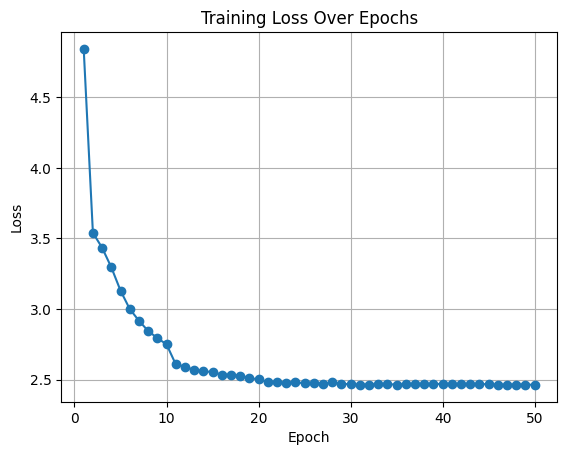

In [2]:
# 訓練模型
train_model(50, start_epoch=start_epoch, loss_history=loss_history)

In [3]:
# 推論模型
evaluate_model(test_loader)

Accuracy: 0.3089
Precision: 0.3117
Recall: 0.3089
F1 Score: 0.3005
              precision    recall  f1-score   support

           0       0.15      0.22      0.18         9
           1       0.11      0.11      0.11         9
           2       0.23      0.33      0.27         9
           3       0.33      0.33      0.33         9
           4       0.55      0.67      0.60         9
           5       0.21      0.33      0.26         9
           6       0.38      0.33      0.35         9
           7       0.27      0.33      0.30         9
           8       0.18      0.22      0.20         9
           9       0.33      0.11      0.17         9
          10       0.00      0.00      0.00         9
          11       0.20      0.11      0.14         9
          12       0.40      0.22      0.29         9
          13       0.33      0.22      0.27         9
          14       0.38      0.33      0.35         9
          15       0.08      0.11      0.09         9
          16  